In [2]:
from sqlalchemy import create_engine
import pandas as pd
import geopandas as gp
import numpy as np
from scipy.stats import norm
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors

import config as cfg

# Config and Setup
CMAP = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","blue","purple"])
conn_str = cfg.credentials[cfg.ENV]
engine = create_engine(conn_str, echo=cfg.DEBUG)
print(f'Using ENV: {cfg.ENV} \n' + '=' * 100)
engine.connect() # Test that connection is working

Using ENV: prod 
2020-10-27 10:17:16,876 INFO sqlalchemy.engine.base.Engine select version()
2020-10-27 10:17:16,877 INFO sqlalchemy.engine.base.Engine {}
2020-10-27 10:17:16,942 INFO sqlalchemy.engine.base.Engine select current_schema()
2020-10-27 10:17:16,942 INFO sqlalchemy.engine.base.Engine {}
2020-10-27 10:17:17,021 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-10-27 10:17:17,022 INFO sqlalchemy.engine.base.Engine {}
2020-10-27 10:17:17,056 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-10-27 10:17:17,058 INFO sqlalchemy.engine.base.Engine {}
2020-10-27 10:17:17,091 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2020-10-27 10:17:17,093 INFO sqlalchemy.engine.base.Engine {}


# Goal of the Score
- Provide investors a way of assessing risk in an unfamiliar market with a quick glance at a map (similar to a FICO score for creditors or a Bond Rating for a bond) 
- http://3.22.0.171:8080/
- Be able to generate the score for all areas, at various levels of granularity, and across time (No hard-coding of information needed)

# Validation
- Expert maps 
- User Feedback
- Own personal market knowledge (Cleveland, Chicago, SF) 

# Data 
- Using the American Community Survey

# Expert Maps
 - Cleveland: https://www.biggerpockets.com/member-blogs/4704/42419-cleveland-neighborhood-grades
 https://www.clevelandinvestorprimer.com/area-guide/grade-map/
 - Kansas City: https://bp-v-newproduction.s3.amazonaws.com/uploads/uploaded_images/normal_1464721609-KC_Zip_code_heat_map.jpg
 https://www.biggerpockets.com/member-blogs/4704/88461-the-ultimate-guide-to-grading-kansas-city-missouri-neighborhoods
 - Indianapolis: https://www.biggerpockets.com/blog/guide-grading-indianapolis-neighborhoods
 - Birmingham AL: https://www.biggerpockets.com/member-blogs/4704/86358-the-ultimate-guide-to-grading-birmingham-alabama-neighborhoods
 - Austin: https://www.biggerpockets.com/member-blogs/8592/61981-ultimate-guide---austin-neighborhood-grades

# SQL Queries

In [3]:
# See all GATS
[n[0] for n in engine.execute("select distinct area_type from locations_geographicareameta;")]

2020-10-27 10:17:20,647 INFO sqlalchemy.engine.base.Engine select distinct area_type from locations_geographicareameta;
2020-10-27 10:17:20,648 INFO sqlalchemy.engine.base.Engine {}


['ZCTA5',
 'HOOD',
 'STATE',
 'TRACT',
 'US',
 'PLACE',
 'DIVISION',
 'COUSUB',
 'BG',
 'COUNTY',
 'CBSA',
 'REGION']

In [4]:
GAT = 'COUNTY'
YEAR = 2019
DIFF_YEARS = 5

# Make state_ids list
state_ids = [n[0] for n in engine.execute("select distinct geo_id from locations_geographicareameta where area_type='STATE';")]

def make_delta_query(n):
    delta_query = f"""
        case 
            when t1.{n} is not null then 
                cast(t1.{n} as numeric)/cast(t2.{n} as numeric)
            else 
                null
        end as {n}_delta
    """
    
    return delta_query

economic_analysis_regions = {
    "New England" : ["09", "23", "25", "33", "44", "50"],
    "Midwest" : ["10", "11", "24", "34", "36", "42"],
    "Great Lakes": ["17", "18", "26", "39", "55"],
    "Plains": ["19", "20", "27", "29", "31", "38", "46"],
    "Southeast": ["01", "05", "12", "13", "21", "22", "28", "37", "45", "47", "51", "54"],
    "Southwest": ["04", "35", "40", "48"],
    "Rocky Mountain": ["08", "16", "30", "49", "56"],
    "Far West": ["02", "06", "15", "32", "41", "53"],
    # "Puerto Rico": ["72"]
}

query_values = [
    "lgm.geo_id", 
    'lgm."name"',
    "lg.year",
    "lg.total_population",
    # Score Vars 
    "lg.median_household_income",
    "lg.percentage_owner_occupied_units",
    "lg.percentage_occupied_housing_units",
    "lg.percent_college_educated",
    "lg.non_snaps_percentage",
    "lg.non_poverty_percentage",
    "lg.income_to_rent_ratio"
]

delta_columns = [
    "median_household_income",
    "percentage_occupied_housing_units",
    "percent_college_educated",
    "non_poverty_percentage",
]
    
sql = f"""
    with  
        t1 as (
            select 
                {','.join(query_values)}
            from locations_geographicarea lg
            join locations_geographicareameta lgm on lg.meta_id = lgm.id
            where lgm.area_type='{GAT}' and lg."year"={YEAR}
        ), t2 as (
            select 
                {','.join(query_values)}
            from locations_geographicarea lg
            join locations_geographicareameta lgm on lg.meta_id = lgm.id
            where lgm.area_type='{GAT}' and lg."year"={YEAR-DIFF_YEARS}
        )
        select 
            {','.join(["t1."+ n.split(".")[1] for n in query_values])},
            {','.join([make_delta_query(n) for n in delta_columns])}
        from t1 as t1, t2 as t2 
        where t1.GEO_ID=t2.GEO_ID;
"""    

result = engine.execute(sql)
df = pd.DataFrame(result, columns=query_values+[n+"_delta" for n in delta_columns])
df = df.dropna(subset = [col+"_delta" for col in delta_columns])

for col in delta_columns:
    df[col+"_delta"] = df[col+"_delta"].apply(lambda x: float(x))

df.head()

2020-10-27 10:17:22,360 INFO sqlalchemy.engine.base.Engine select distinct geo_id from locations_geographicareameta where area_type='STATE';
2020-10-27 10:17:22,361 INFO sqlalchemy.engine.base.Engine {}
2020-10-27 10:17:22,456 INFO sqlalchemy.engine.base.Engine 
    with  
        t1 as (
            select 
                lgm.geo_id,lgm."name",lg.year,lg.total_population,lg.median_household_income,lg.percentage_owner_occupied_units,lg.percentage_occupied_housing_units,lg.percent_college_educated,lg.non_snaps_percentage,lg.non_poverty_percentage,lg.income_to_rent_ratio
            from locations_geographicarea lg
            join locations_geographicareameta lgm on lg.meta_id = lgm.id
            where lgm.area_type='COUNTY' and lg."year"=2019
        ), t2 as (
            select 
                lgm.geo_id,lgm."name",lg.year,lg.total_population,lg.median_household_income,lg.percentage_owner_occupied_units,lg.percentage_occupied_housing_units,lg.percent_college_educated,lg.non_snaps_

,lgm.geo_id,"lgm.""name""",lg.year,lg.total_population,lg.median_household_income,lg.percentage_owner_occupied_units,lg.percentage_occupied_housing_units,lg.percent_college_educated,lg.non_snaps_percentage,lg.non_poverty_percentage,lg.income_to_rent_ratio,median_household_income_delta,percentage_occupied_housing_units_delta,percent_college_educated_delta,non_poverty_percentage_delta
0,01001,"Autauga County, Alabama",2019,55200,58786.0,74.894625,91.331761,27.689286,87.250770,84.621565,636.212121,1.095078,0.994264,1.322801,0.963068
1,01003,"Baldwin County, Alabama",2019,218022,56813.0,75.460174,80.073222,31.358910,92.378534,91.056627,569.725231,1.266056,1.029225,1.083158,1.065321
2,01005,"Barbour County, Alabama",2019,25782,34186.0,61.397779,85.264304,12.215925,72.610494,71.136682,713.993317,1.038741,0.991191,0.911418,0.969916
3,01007,"Bibb County, Alabama",2019,22527,45340.0,75.073099,76.487283,11.489227,87.587719,86.012312,821.376812,1.243998,0.945148,0.952160,1.050697
4,01009,"Blount County, Alabama",2019,57645,48695.0,78.626214,86.281067,12.642895,90.456311,85.599664,916.008277,1.103069,0.954720,1.045616,1.016759


# Score Code

In [4]:
class risk_class():
    
    def grade(self, item):
        # Grade dict with lists of score percentile ranges as values
        grade_dict = {
            "A": [0,0.15],
            "B": [0.15,0.45],
            "C": [0.45,0.8],
            "D": [0.8,0.95],
            "F": [0.95,1.0],
        }
        for key, val in grade_dict.items():
            if item<=(1-val[0]) and item>(1-val[1]):
                return key
        
    def cdf(self, item, key):
        # https://www.desmos.com/calculator/c75qjpkfk9
        return norm.cdf(item, loc=self.norm_dict[key][0], scale=self.norm_dict[key][1])

    def risk_grade_raw(self, items):
        # init empty scores list
        score = []
        # init weights, this can be hardcoded in the future if certain vars need to be weighted higher
        weights = [1 for x in range(len(self.data_cols))]
        # if record contains a nan for any column return None
        if any(math.isnan(item) for item in items):
            return None
        # Loop for column value for the record
        for n, item in enumerate(items):
            # Get the cdf value using the cdf method for each cell value and append to the score list
            score.append(self.cdf(item, self.data_cols[n]) * weights[n])
        # Return the mean of the scores in the score list
        return np.mean(score)

    def score(self, data):
        # Columns that are not considered in the numeric analysis
        exclude_cols = [
            "lgm.geo_id", 
            'lgm."name"',
            'lg.year',
            'lg.total_population',   
        ] 
        # Save geo_ids 
        geo_ids = data["lgm.geo_id"]
        # Drop the columns in the exclude_cols dict
        data = data.drop(exclude_cols, axis=1)
        # Make dict containing the mean and std of each column
        self.norm_dict = {
            column:[
                data[column].mean(), 
                data[column].std()
            ] for column in data.columns
        }
        # Used in the risk_grade_raw method
        self.data_cols = data.columns
        # Grab "raw scors" for each record using risk_grade_raw method
        data["raw_score"] = data.apply(lambda row: self.risk_grade_raw([row[data.columns[n]] for n in range(len(self.data_cols))]), axis=1)
        # Add back geo_ids   
        data["lgm.geo_id"] = geo_ids
        # Exlude all Null raw_score values 
        data = data[data['raw_score'].notnull()]
        # Get mean of raw_score col
        raw_score_mean = data.raw_score.mean()
        # Get std of raw_score col
        raw_score_std = data.raw_score.std()
        # Get the cdf value of the raw_score col and assign to raw_score_norm col
        data["raw_score_norm"] = norm.cdf(data["raw_score"], loc=raw_score_mean, scale=raw_score_std)
        # Set risk_grade column
        data["risk_grade"] = data.raw_score_norm.apply(self.grade)
        
        return data[['lgm.geo_id', 'raw_score', 'raw_score_norm', 'risk_grade']]

# Mathematical Formula 

Input Vectors

$P = \begin{bmatrix}
        x_{11} & x_{12} & \ldots & x_{1n}   
        \\[0.3em]   
        x_{21} & x_{22} & \ldots & x_{2n} 
        \\[0.3em]   
        \vdots & \vdots & \ddots & \vdots \\[0.3em]
        x_{m1} & x_{m2} & \ldots & x_{mn}      
\end{bmatrix}$

$\textit{n} = \text{number of variables used}$

$\textit{m} = \text{number of records for given anaysis cohort}$

Vectors Containing Mean and Standard Deviation for each column $n$ in matrix $P$

$\vec{P_{mean}} = \text{mean}(P_{*,n})$ for $n$ in $P$

$\vec{P_{std}} = {\sqrt {\frac {\sum _{i=1}^{m}(P_{i,n}-{\overline {P_{*,n}}})^{2}}{m-1}}}$ for $n$ in $P$

Weights Vector

$\vec{w} = (w_1,w_2,\ldots,w_n)$

Cumulative Distribution Function

$\Phi(x, \mu, \sigma) = \frac{1}{2} \left[ 1+ \operatorname{erf} \left(\frac{x-\mu}{\sigma\sqrt{2}}\right) \right]$

$\vec{R} = \text{mean}\left(\sum_{i=1}^{n} \Phi(P_{m,i}, \vec{P_{mean{i}}}, \vec{P_{std_{i}}})\right)$ for $m$ in $P$

$R_{mean} = \text{mean}(\vec{R})$

$R_{std} = {\sqrt {\frac {\sum _{i=1}^{m}(R_{i}-{\overline {\vec{R}}})^{2}}{m-1}}}$

$\vec{R_{norm}} = \Phi(\vec{R}, R_{mean}, R_{std})$

$\vec{R_{norm}} = \text{sorted}(\vec{R_{norm}}, \text{ascending=False})$

$
  S(i) =
  \begin{cases}
        \text{A} & \text{if $i_m<\lfloor{m \cdot 0.10}\rfloor$} \\
        \text{B} & \text{if $\lfloor{m \cdot 0.10}\rfloor\leq i_m<\lfloor{m \cdot 0.35}\rfloor$} \\
        \text{C} & \text{if $\lfloor{m \cdot 0.35}\rfloor \leq i_m<\lfloor{m \cdot 0.65}\rfloor$} \\
        \text{D} & \text{if $\lfloor{m \cdot 0.65}\rfloor \leq i_m<\lfloor{m \cdot 0.90}\rfloor$} \\
        \text{F} & \text{if $i_m \geq \lfloor{m \cdot 0.90}\rfloor$}
  \end{cases}
$

$S(\vec{R_{norm}})$

Steps:
 - Based on GAT use appropriate regionalization techniques
 - Select Only Numeric Variables Used
 - Get Mean and Std of each variable used
 - Compute Risk Grade Raw using CDF based on the Mean and Std of each of the variables 
 - If any NaN, return None
 - Build list of CDF values for each variable for each row in set
 - Return mean for list of CDF values to get raw_score
 - Compute Mean and Std for raw score list
 - Noralize all in raw score using CDF function and above mean and std
 - Set Ordinal Grade based on grade dict ranges and normalized raw_score values

# Run Score

In [5]:
risk = risk_class()
risk_df_list = []
    
if GAT in ["STATE","CBSA", "REGION", "DIVISION", "US"]: # Run score on un-regionalized basis if STATE, MSA, Census Region or Division or Country
    df = df.loc[df["lgm.geo_id"]!='72'] # Exclude Puerto Rico since it's an outlier in almost every metric at the State level
    risk_df_list.append(risk.score(df))
    
elif GAT in ["COUNTY"]:
    for value in tqdm(economic_analysis_regions.values()):
        # Use records from states in economic_analysis_regions when GAT is COUNTY
        risk_df_list.append(risk.score(df[df["lgm.geo_id"].str[:2].isin(value)]))

else:
    for state_id in tqdm(state_ids):
        # Conditional for Washington D.C.
        if state_id == "11" and GAT in ["COUSUB", "PLACE"]:
            # If DC use DC and Virginia since DC is too smale to properly sample when GAT is of size COUSUB or PLACE
            risk_df = risk.score(df[df["lgm.geo_id"].str[:2].isin([state_id, 51])])
        else:
            # Else only use GATs from the State in question 
            risk_df = risk.score(df[df["lgm.geo_id"].str[:2]==state_id])
        
        risk_df_list.append(risk_df)
        
risk_df = pd.concat(risk_df_list)
df = df.merge(risk_df, on="lgm.geo_id").sort_values("risk_grade", ascending=True)
df[['lgm."name"', "risk_grade"]].sample(10)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.72it/s]


,"lgm.""name""",risk_grade
2218,"Bledsoe County, Tennessee",B
378,"Butts County, Georgia",D
2092,"Northumberland County, Pennsylvania",C
849,"Geary County, Kansas",D
2660,"York County, Virginia",A
629,"Shelby County, Illinois",B
1858,"Morton County, North Dakota",B
1674,"Eddy County, New Mexico",B
1960,"Choctaw County, Oklahoma",F
1283,"Steele County, Minnesota",B


In [12]:
df.columns

Index(['lgm.geo_id', 'lgm."name"', 'lg.year', 'lg.total_population',
       'lg.median_household_income', 'lg.percentage_owner_occupied_units',
       'lg.percentage_occupied_housing_units', 'lg.percent_college_educated',
       'lg.non_snaps_percentage', 'lg.non_poverty_percentage',
       'lg.income_to_rent_ratio', 'median_household_income_delta',
       'percentage_occupied_housing_units_delta',
       'percent_college_educated_delta', 'non_poverty_percentage_delta',
       'raw_score', 'raw_score_norm', 'risk_grade'],
      dtype='object')

# Charts

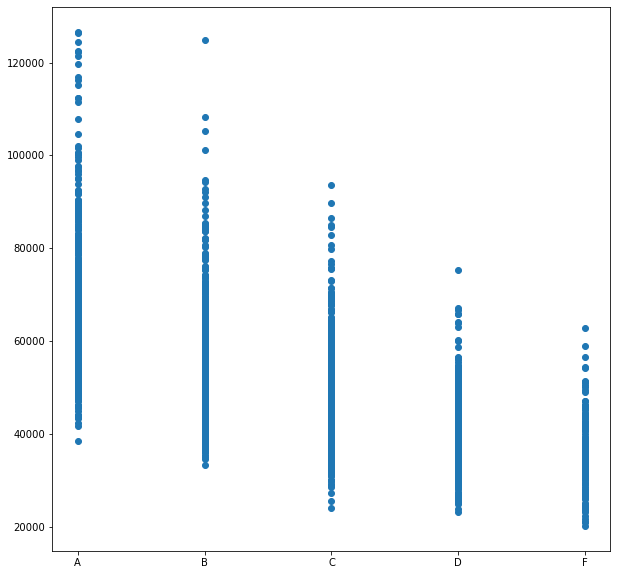

In [6]:
f, ax = plt.subplots(1, figsize=(10,10))

plt.scatter(
    df["risk_grade"],
    df["lg.median_household_income"],
)

plt.show()

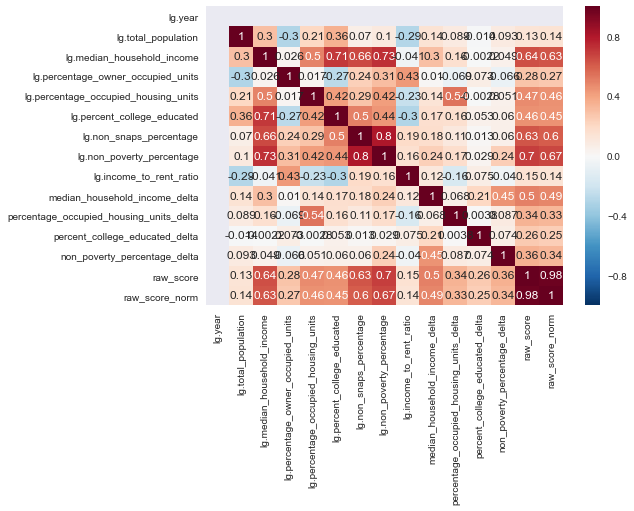

In [7]:
import seaborn as sn
corr = df.corr()
sn.heatmap(corr, annot=True)
plt.show()

In [8]:
df[["lgm.geo_id","risk_grade"]].groupby("risk_grade").agg('count').reset_index()

,risk_grade,lgm.geo_id
0,A,487
1,B,807
2,C,973
3,D,439
4,F,148


<AxesSubplot:>

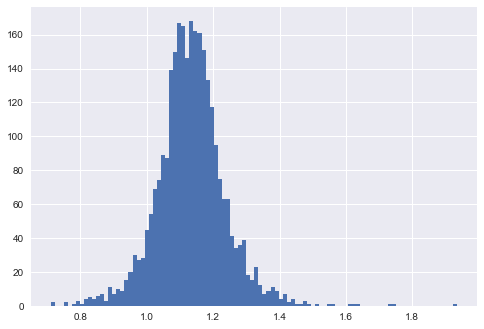

In [126]:
df["median_household_income_delta"].hist(bins=100)

# Issue 
- Modifiable areal unit problem: https://en.wikipedia.org/wiki/Modifiable_areal_unit_problem
- Homogeneity: If a census tract contains blocks of single family houses, but also a large number of senior citizen rental housing apartment communities, the parameters related to income and owner occupancy rate might score far lower than they would have if the senior citizen housing complexes were excluded, thus bringing down the overall grade for the area.
- Missing data, impute or remove


# KPIs to Try

### Census 
- Population Density / Total Urban/Suburban Land Area / Total Major Cities 
- Population Change - Brain Drain (Segment by type of population change (births, deaths, new residents, types of new residents)
- Change in Real Estate Prices 
- Employment Percentage (Types of Jobs and Types of Businesses (serving local or national clients)
- Employment Diversity 
- Mortgage Delinquency ?
- Income Growth Inflation Adjusted 
- Cash Flow = Rent x 12 - DebtService x 12 - PropertyTaxRate x PurchasePrice
- Poverty Percentage 
- Household Size vs Housing Units 
- Median Rent
- Rent to Income Ratio 
- Renters as a percentage of the population

### Other
- Job Growth
- Absorption Rates
- Natural Disasters 
- Public Debt/ Budget Deficit/ Surplus 
- Taxes (Income, Real Estate, Sales)
- Crime
- School Rankings 
- New Constructions (To much could indicate more risk tho)
- Average Cost of Homeowners Insurance / Landlord Insurance 
- Average Household Debt not including Mortgage 
- Landlord Law Friendliness Index 
- State and City Planning Initiatives
- Varying Interest Rates 
- Number of Fortune 500 Companies HQ in State
- GDP per Capita 
- Climate 
- Social Media Mentions 
- Position in 4 Phase Market Cycle 
- Health Data 
- Physical Property Entropy Index
- Energy Costs
- Ease of Building New Construction 



# Map

In [ ]:
result = engine.execute(
    f"""select 
        lgm.geo_id,
        lg.geom as geometry
    from locations_geographicarea lg
    join locations_geographicareameta lgm on lg.meta_id = lgm.id
    where lgm.area_type='{GAT}' and lg."year"={YEAR}
    """
)
gdf = gp.GeoDataFrame(result, columns=["lgm.geo_id","geometry"])

In [ ]:
column = "risk_grade"
title = f"Risk Score Choropleth for {GAT}"
vmin = states_gdf[column].min()
vmax = states_gdf[column].max()

ax = states_gdf.plot(
    column=column,
    cmap=CMAP,
    figsize=(25, 25),
    alpha=0.5,
    edgecolor='black',
    linewidth=1,
)

util.add_basemap(ax, zoom=4, url=ctx.sources.ST_TONER_LITE)

ax.set_xlim(-19000000, -7000000)
ax.set_ylim(1750000, 10000000)

fig = ax.get_figure()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Add color bar
cbax = fig.add_axes([0.95, 0.25, 0.03, 0.5])   
cbax.set_title("Price to Rent Ratio", fontsize= 15)
sm = plt.cm.ScalarMappable(cmap=CMAP, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cbax)

ax.set_title(title, fontdict={
    'fontsize': 30, 'fontweight': 'medium'})


plt.savefig('images/{}.jpg'.format(title),  dpi=300, bbox_inches = "tight")
plt.show()